<a href="https://colab.research.google.com/github/CeHaga/mnist-gan/blob/main/Mnist_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Number Generation with GAN
Application of a Generative Adversarial Network to generate handwritten numbers using MNIST dataset.

Made with help of this tutorial: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

## Bibliotecas

In [ ]:
from matplotlib import pyplot

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint

from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

## Discriminador

### Definição do Discriminador

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()

  # 1: Procura características marcantes
  # 64 filtros
  # Convolução 3x3
  # Leitura de 2 em 2 pixels
  # Padding na imagem para mesmo tamanho de filtro
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
 
  # 2: Mapeia essas características pra uma função de ativação
  # ReLU com inclinação negativa de 0.2
  model.add(LeakyReLU(alpha=0.2))

  # 3: Ignora 40% das características quando estive treinando
  # Cada nó da camada anterior tem uma probabilidade de 40% de ser removido durante o treino
  model.add(Dropout(0.4))
 
  # 4: Procura características mais detalhadas, depois das marcantes
  # Mais um desse conjunto
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
 
  # Junta tudo e finaliza com sigmoide
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
 
 
	# Compila
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
discriminator = define_discriminator()
print(discriminator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

### Treinamento do Discriminador

In [ ]:
def load_real_samples():
  # Pega apenas os números de treino do MNIST
  (trainX, _), (_, _) = load_data()

  # Adiciona uma dimensão extra de cor, pois são 3 dimensões de entrada
  X = expand_dims(trainX, axis=-1)

  # Coloca no intervalo [0,1]
  X = X.astype('float32')
  X /= 255.

  return X

In [ ]:
def generate_real_samples(dataset, n_samples):
  # Escolhe n_samples números aleatórios
  ix = randint(0, dataset.shape[0], n_samples)

  # Pega as imagens aleatórias
  X = dataset[ix]

  # Atribui a classe 1 (Real)
  y = ones((n_samples, 1))

  return X,y

In [ ]:
def generate_fake_samples(n_samples):
  # Gera um número aleatório para cada pixel de cada amostra
  X = rand(28 * 28 * n_samples)

  # Coloca no formato de entrada
  X = X.reshape((n_samples, 28, 28, 1))

  # Atribui a classe 0 (Falso) 
  y = zeros((n_samples, 1))
  
  return X,y

In [ ]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch / 2)

  # Fazer cada época manualmente (Por ser pouco treino)
  for i in range(n_iter):
    # Gera imagens reais e treina
    X_real, y_real = generate_real_samples(dataset, half_batch)
    _, real_acc = model.train_on_batch(X_real, y_real)

    # Gera imagens falsas e treina
    X_fake, y_fake = generate_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

## GAN

### Definição do Gerador

In [ ]:
# Será feito o processo inverso do gerador, criando mapas de características aleatórios como entrada
def define_generator(latent_dim):
  model = Sequential()

  # Camada densa permitindo 128 imagens de 7x7
  model.add(Dense(7*7*128, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))

  # Aumenta para 128 imagens de 14x14 
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Aumenta para 128 imagens de 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Convoluciona os 128 mapas em 1 única saída
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

  return model

In [ ]:
# Gera números aleatórios para a entrada do gerador
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
# Sobreescreve a função de gerar dados falsos, adicionando o gerador
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  
  # Prediz os resultados do gerador e define a classe 0 (Falso)
  X = g_model.predict(x_input)
  y = zeros((n_samples, 1))
  
  return X, y

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

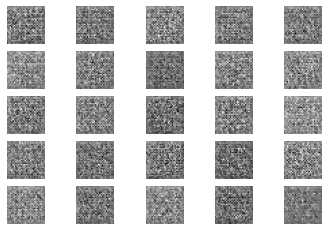

In [ ]:
latent_dim = 100
n_samples = 25

generator = define_generator(latent_dim)
print(generator.summary())

X, _ = generate_fake_samples(generator, latent_dim, n_samples)

# Mostra os n_samples exemplos
for i in range(n_samples):
	pyplot.subplot(5, 5, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')

pyplot.show()

### Definição da GAN



In [ ]:
def define_gan(g_model, d_model):
  # O discriminador não será treinável a partir de agora, mas é possível treinar ele separado
  d_model.trainable = False

  # Junta os 2 modelos
  model = Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
model = define_gan(g_model, d_model)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________
None


### Treinamento da GAN

In [ ]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
  for i in range(n_epochs):
    # Gera as entradas aleatórias
    x_gan = generate_latent_points(latent_dim, n_batch)
    
    # Define a classe de todas como 1 (Real)
    # Isso é feito pois o treinamento da GAN é para treinar o gerador
    # O gerador vai bem quando o discriminador vai mal
    y_gan = ones((n_batch, 1))

    gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
# Plota as previsões do modelo
def save_plot(examples, epoch, n=10, path='drive/MyDrive/Checkpoints/MNIST_GAN/'):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(path+filename)
	pyplot.close()

In [ ]:
# Para avaliar a perfomance não há um método objetivo
# A cada X épocas é possível salvar a acurácia de cada modelo, algumas previsões e seus pesos
# Com isso, é possível avaliar manualmente e retornar a algum checkpoint considerado melhor
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100, path='drive/MyDrive/Checkpoints/MNIST_GAN/'):
  # Vê a acurácia do discriminador para dados reais e falsos
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)

  # Salva um checkpoint do modelo
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(path+filename)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  # Separa as batches
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      # Gera amostras reais
      X_real, y_real = generate_real_samples(dataset, half_batch)
      
      # Gera amostras falsas
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      
      # Junta os dados reais e falsos para treinar o discriminador
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

      # Treina o discriminador
      d_loss, _ = d_model.train_on_batch(X, y)

      # Gera a entrada de pontos aleatórios
      X_gan = generate_latent_points(latent_dim, n_batch)

      # Define a classe como 1 (Real)
      # É trocado pois treinar a GAN é treinar o gerador
      # O gerador vai bem quando o discriminador erra
      y_gan = ones((n_batch, 1))

      # Treina o gerador
      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      print('Época %d: %.2f%%, Dis = %.3f, Gen = %.3f' % (i+1, (j+1)*100./bat_per_epo, d_loss, g_loss))

      if (i+1) % 10 == 0 and j == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
dataset = load_real_samples()
train(g_model, d_model, model, dataset, latent_dim)

A saída de streaming foi truncada nas últimas 5000 linhas.
Época 79: 64.96%, Dis = 0.685, Gen = 0.690
Época 79: 65.38%, Dis = 0.699, Gen = 0.700
Época 79: 65.81%, Dis = 0.688, Gen = 0.711
Época 79: 66.24%, Dis = 0.692, Gen = 0.706
Época 79: 66.67%, Dis = 0.692, Gen = 0.699
Época 79: 67.09%, Dis = 0.691, Gen = 0.689
Época 79: 67.52%, Dis = 0.695, Gen = 0.697
Época 79: 67.95%, Dis = 0.687, Gen = 0.706
Época 79: 68.38%, Dis = 0.693, Gen = 0.698
Época 79: 68.80%, Dis = 0.690, Gen = 0.695
Época 79: 69.23%, Dis = 0.696, Gen = 0.692
Época 79: 69.66%, Dis = 0.690, Gen = 0.702
Época 79: 70.09%, Dis = 0.699, Gen = 0.712
Época 79: 70.51%, Dis = 0.693, Gen = 0.714
Época 79: 70.94%, Dis = 0.686, Gen = 0.705
Época 79: 71.37%, Dis = 0.695, Gen = 0.701
Época 79: 71.79%, Dis = 0.694, Gen = 0.689
Época 79: 72.22%, Dis = 0.692, Gen = 0.688
Época 79: 72.65%, Dis = 0.690, Gen = 0.700
Época 79: 73.08%, Dis = 0.689, Gen = 0.713
Época 79: 73.50%, Dis = 0.694, Gen = 0.706
Época 79: 73.93%, Dis = 0.692, Gen = 0

## Resultados

In [13]:
from IPython.display import Image

images = [f'/content/drive/MyDrive/Checkpoints/MNIST_GAN/generated_plot_e%03d.png' % (i*10) for i in range(1,11)]

Época 10:



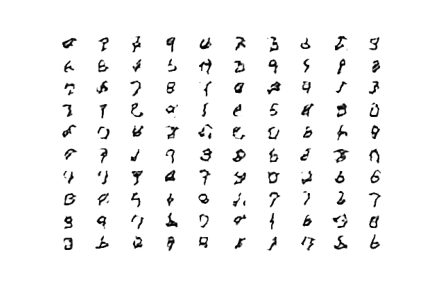

In [14]:
print('Época 10:\n')
Image(images[0])

Época 20:



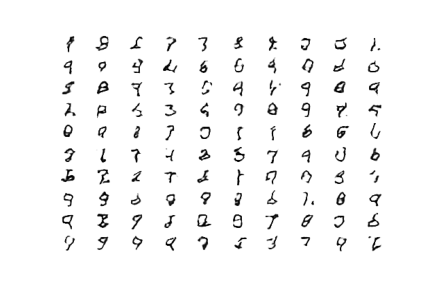

In [15]:
print('Época 20:\n')
Image(images[1])

Época 30:



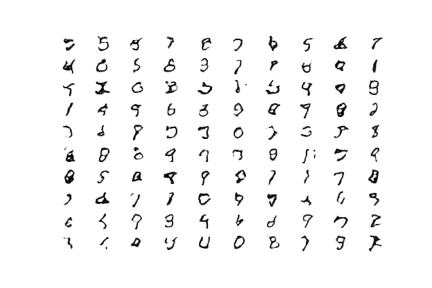

In [16]:
print('Época 30:\n')
Image(images[2])

Época 40:



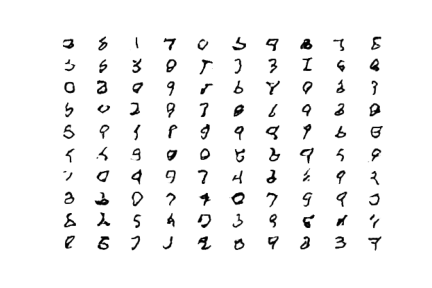

In [17]:
print('Época 40:\n')
Image(images[3])

Época 50:



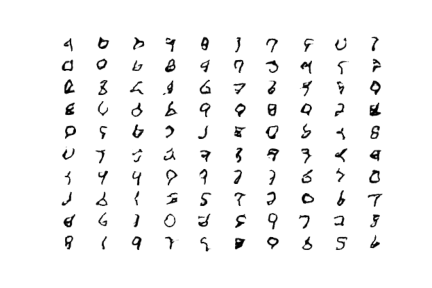

In [18]:
print('Época 50:\n')
Image(images[4])

Época 60:



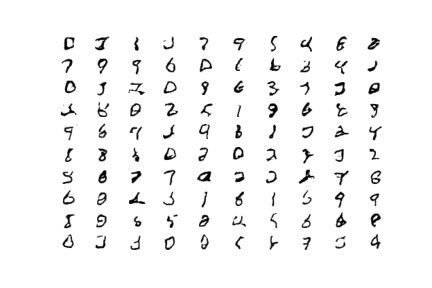

In [19]:
print('Época 60:\n')
Image(images[5])

Época 70:



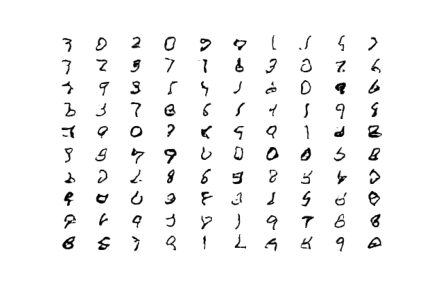

In [20]:
print('Época 70:\n')
Image(images[6])

Época 80:



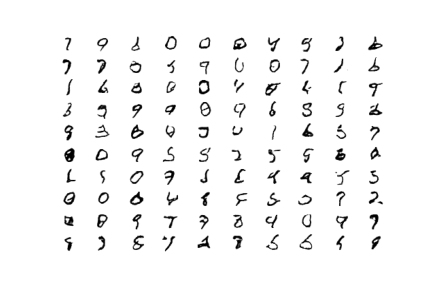

In [21]:
print('Época 80:\n')
Image(images[7])

Época 90:



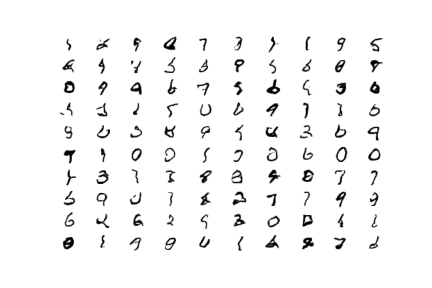

In [22]:
print('Época 90:\n')
Image(images[8])

Época 100:



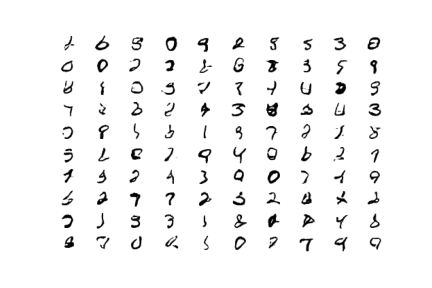

In [23]:
print('Época 100:\n')
Image(images[9])